<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2019</span></p>
<p><font size="4">  UE Stochastic dynamic systems </font></p>
<p></p>
<p><font size="5">  Notebook 01: Julia lab - Kalman and particle filters </font></p>
</p></br>
</p>
</CENTER>


----------------------------

# <span style="color:#00B8DE">I - Kalman filter (lab 1&2)</span>

Let 

$$
M_t=\sqrt{t}\begin{bmatrix}\cos(2\pi ft)\\ \sin(2\pi ft)\end{bmatrix}
$$

denote the trajectory of a point in a 2D space, with $t=1:T$. The corresponding speed will be calculated using backward finite difference. A noisy version of the trajectory and its speed are observed using a radar. The noise covariance matrix is in the form ${\bf \Sigma}_n=\sigma_n^2\mathbb{I}_4$. We model the system using a simple kinematic model in the form of a state space model where the state vector consists of the position, the speed and the acceleration of the point (as in the lesson). The acceleration is modeled by an $AR(1)$ process: $A_{t+1}=\rho A_t+v_{A,t}$ with ${\bf \Sigma}_{v_A}=\sigma_{v_A}^2\mathbb{I}_2$. We shall write the model 

$$
X_{t+1}={\bf F} X_t +{\bf G} v_t\\
Y_t = {\bf H} X_t+{\bf U} n_t
$$

>- 1) Plot the noiseless and noisy trajectories of position and speed with $T=200$;
>- 2) Give the expressions of ${\bf F}$ and ${\bf H}$ and give the expressions of the matrices ${\bf D}_Q$ and ${\bf D}_R$ in covariance matrices ${\bf Q}=cov[{\bf G} v_t]=σ_v^2 {\bf D}_Q$ and ${\bf R}=cov[{\bf U} n_t]=σ_n^2 {\bf D}_R$;
>- 3) Denoting by  ${\bf K}$, ${\bf P}\_$ and ${\bf P}$ the Kalman gain, and covariance matrices of prediction and filtering errors respectively implement the Kalman filter;
>- 4) Plot the trajectories of position and speed estimated using the Kalman filter. Check the robustness of the estimation with respect to the choice of the parameters of the model;
>- 5) Implement Kalman smoother and check the improvment brought compared to the Kalman filter.

In [1]:
using LinearAlgebra 
using Plots         
using Distributions 

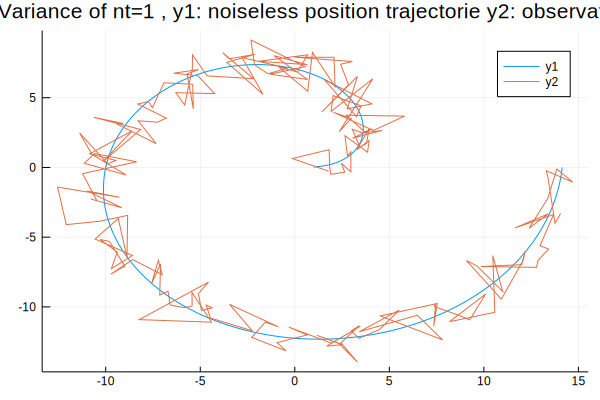

In [2]:
#--------------------------
# PART I : Kalman filter
#--------------------------
# Trajectory synthesis
#---------------------
T = 200
f = 1/T
t = range(1, stop = T)
σn = 1
σVa = 1


noiseY = σn * randn(4, T)                 #Nt 
X = sqrt.(t) .* cos.(2*pi*f*t)            #Position X
Y = sqrt.(t) .* sin.(2*pi*f*t)            #Position Y
Vx = 1 ./(2 * sqrt.(t)) .* cos.(2*pi*f*t) - 2*pi*f*sqrt.(t) .* sin.(2*pi*f*t) #Speed X   
Vy = 1 ./(2 * sqrt.(t)) .* sin.(2*pi*f*t) + 2*pi*f*sqrt.(t) .* cos.(2*pi*f*t) #Speed Y 
#Plot noiseless trajectory of the position
plot(X,Y)

# noiseless trajectories
Y_composed = vcat(reshape(X,(1,200)), reshape(Y,(1,200)), reshape(Vx,(1,200)), reshape(Vy,(1,200)))
# noisy trajectories
Y_composed = Y_composed .+ noiseY

#Plot noisy trajectory of the positions
plot!(Y_composed[1,:],Y_composed[2,:], title="Variance of nt=1 , y1: noiseless position trajectorie y2: observation")

In [3]:
#matrix Ft 
F= zeros(6,6) 
for i in range(1, stop=6)
    for j in range(1,stop=6)
        if i==j || i+2==j
            F[i,j] = 1
        end
    end
end

#matrix Ht
H= zeros(4,6)
for i in range(1, stop=4)
    for j in range(1,stop=6)
        if i==j
            H[i,j] = 1
        end
    end
end

#matrix Q=Dq cause (σv)^2 =1  
Q= zeros(6,6)
Q[5,5] = 1; Q[6,6] = 1  

#matrix R=Dr cause (σn)^2 = 1
R = zeros(4,4)
for i in range(1, stop=4)
    for j in range(1,stop=4)
        if i==j
            R[i,j] = 1
        end
    end
end

#matrix Gt
G = zeros(6,6)
G[5,5] = 1; G[6,6] = 1

#matrix Ut
U = zeros(4,4)
for i in range(1, stop=4)
    for j in range(1,stop=4)
        if i==j
            U[i,j] = 1
        end
    end
end

In [4]:
# initialization 
record = zeros(6,200)
Xt_1_t_1 = zeros(6,1)
Pt_1_t_1 =  zeros(6,6)
for i in range(1, stop=6)
    for j in range(1,stop=6)
        if i==j
            Pt_1_t_1[i,j] = 1e-2
        end
    end
end

#iteration of kalman filter 
for i in range(1, stop=200)
    Xt_t_1 = F * Xt_1_t_1
    Pt_t_1 = F * Pt_1_t_1 * F' + G*Q*G'
    Kt = Pt_t_1*H'*inv(H*Pt_t_1*H'+U*R*U') # kalman gain 
    Xt_t=Xt_t_1+Kt*(Y_composed[:,i]-H*Xt_t_1)
    record[:,i] = Xt_t
    #Pt_t=Pt_t_1-Kt*H*Pt_t_1 
    Pt_t=Pt_t_1-Kt*(H*Pt_t_1*H'+U*R*U')*Kt'
    Xt_1_t_1 = Xt_t
    Pt_1_t_1 = Pt_t
   
    
end

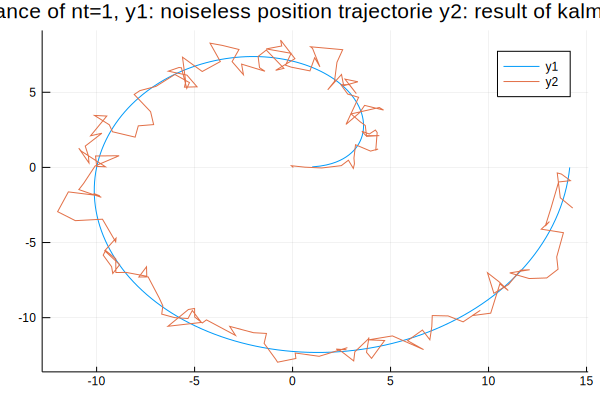

In [5]:
plot(X,Y, title="Variance of nt=1, y1: noiseless position trajectorie  y2: result of kalman filter")
plot!(record[1,:],record[2,:])

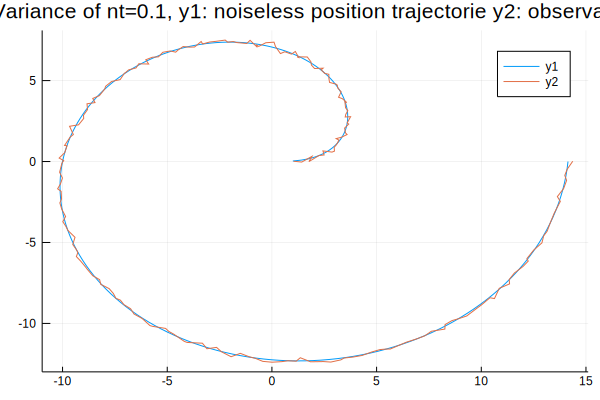

In [6]:
#change the variance to 0.1
σn = 0.1
noiseY = σn * randn(4, T)
# noiseless trajectories
Y_composed = vcat(reshape(X,(1,200)), reshape(Y,(1,200)), reshape(Vx,(1,200)), reshape(Vy,(1,200)))
# noisy trajectories
Y_composed = Y_composed .+ noiseY
#Plot noisy trajectory of the positions
plot(X,Y, title="Variance of nt=0.1, y1: noiseless position trajectorie y2: observation")
plot!(Y_composed[1,:],Y_composed[2,:])

In [7]:
R=0.01*R
# initialization 
record = zeros(6,200)
Xt_1_t_1 = zeros(6,1)
Pt_1_t_1 =  zeros(6,6)
for i in range(1, stop=6)
    for j in range(1,stop=6)
        if i==j
            Pt_1_t_1[i,j] = 1e-2
        end
    end
end

#iteration of kalman filter 
for i in range(1, stop=200)
    Xt_t_1 = F * Xt_1_t_1
    Pt_t_1 = F * Pt_1_t_1 * F' + G*Q*G'
    Kt = Pt_t_1*H'*inv(H*Pt_t_1*H'+U*R*U') # kalman gain 
    Xt_t=Xt_t_1+Kt*(Y_composed[:,i]-H*Xt_t_1)
    record[:,i] = Xt_t
    #Pt_t=Pt_t_1-Kt*H*Pt_t_1 
    Pt_t=Pt_t_1-Kt*(H*Pt_t_1*H'+U*R*U')*Kt'
    Xt_1_t_1 = Xt_t
    Pt_1_t_1 = Pt_t
   
    
end

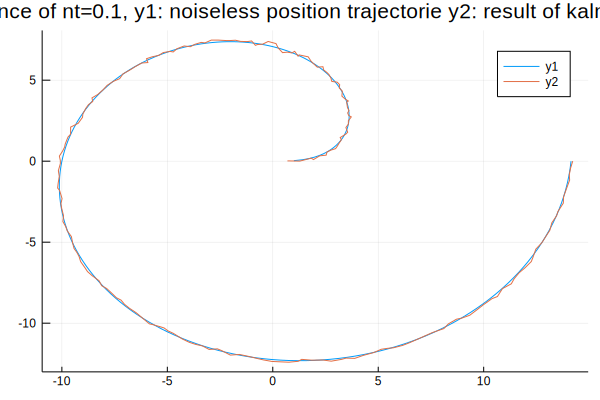

In [8]:
plot(X,Y, title="Variance of nt=0.1, y1: noiseless position trajectorie  y2: result of kalman filter")
plot!(record[1,:],record[2,:])

# <span style="color:#00B8DE">II - Particle filtering (lab 3)</span>

We consider the following nonlinear system:

$$
\begin{array}{lll}
{\text{state: }} &x_{t+1} &= 0.5 x_t + \dfrac{25x_t}{1+x_t^2}+8\cos(1,2t)+ v_t,\\
{\text{observation: }} &y_t &= 0.05 x_t^2+ w_t,
\end{array}
$$

with $v_t$ and $w_t$ having respective distributions $\mathcal{N}(0,0.1)$ and $\mathcal{N}(0,1)$.
We want to estimate recursively the state of the system by using a bootstrap particle filter.
We shall use 100 particles and choose $N_{eff}=90$.

>- 1) Generate a trajectory of $y$ for $t=1:T$ with $T=100$. Plot it as well as the corresponding trajectory of x.
What do we note ? For the model studied here what is the main difficulty met in estimating $x$ from $y$?
>- 2) Simulate $N=10^3$ particles using $p(x_t|x_{t-1}^{(i)})$ as an importance distribution and implement the code for generating particles, calculating weights and normalized weights. Implement resampling and apply it when $N_{eff}<90\% N$. What is the resampling rate ?
>- 3) What occurs as the state noise variance increases ? Explanations ?
>- 4) Possibly test the code with other noise distributions

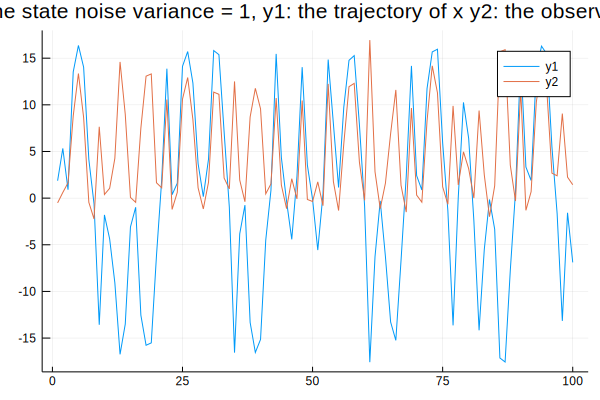

In [9]:
#-----------------------------
# 1) Data model and generation
#-----------------------------
using Distributions

function f_t(x_pre, t)
    return (1/2)*x_pre + (25*x_pre)/(1+x_pre^2) + 8*cos(1.2*t)
end

#process equation
function x_t(f_t, x_pre, t, Q = 0.1)
    return f_t.(x_pre, t) + rand(Normal(0,Q), length(x_pre))
end

function h_t(x_cur)
    return (1/20)*x_cur^2
end

#observation equation
function y_t(h_t, x_cur, R = 1)
    return h_t.(x_cur) + rand(Normal(0, R), length(x_cur))
end

#initial pdf
function x_0(m, vd =0.1)
    return rand(Normal(0, vd), m) 
end


# Graphic outputs
#----------------

function generate_data(x_0, x_t, y_t, tt, R)
    xt = fill(0.0, tt)                    # initialize state vector
    yt = fill(0.0, tt)                    # initialize measurement vector
    x0 = x_0(1)                           # sample one time from initial state pdf
    x_pre = x0
    for i in 1:tt                         # at each time step, generate the state and 
        x_cur = x_t(f_t, x_pre, i, 1)     # measurement using the system equations x_t and y_t
        xt[i] = x_cur[1]
        yt[i] = y_t(h_t, x_cur,R)[1]
        x_pre = x_cur
    end
    return [xt, yt]
end

T = 100
data = generate_data(x_0, x_t, y_t, T, 1)
xt = data[1]
yt = data[2]
plot(xt, title="The state noise variance = 1, y1: the trajectory of x  y2: the observation")
plot!(yt)

For the model studied here what is the main difficulty met in estimating x from y?

For the image above, we find that the relation between the hidden state and the observation is non linear,
so we can't use the kalman filter.

In [10]:
#--------------------------
# 2) Particle sampling
#--------------------------
# Particles initialization
#--------------------------
function particle_filter(data, x_0, x_t, conditional_likelihoods, N, tt, R)
    x_post = fill(0.0, tt)                # initialize x_post
    xt = data[1]                           # states
    yt = data[2]                           # observations
    
    x_pre = x_0(N)                        # Initialization: sample N particlesfrom initial state pdf
    for k = 1:tt
        x_k_pre = x_t(f_t, x_pre, k, 1)   # Prediction: sample from p(x_k|x_k-1)
        likelihood = conditional_likelihoods(h_t, yt[k], x_k_pre, R)  # Update: compute weights p(y_k|x_k)
        if likelihood == fill(0.0, N)
            x_k_post = x_k_pre
        else
            total = sum(likelihood)       # Normalization: normalize weights so that they sum to 1
            likelihood = likelihood./total
            #x_k_post = wsample(x_k_pre, likelihood, length(x_k_pre)) # Resampling: Draw N new particles
            x_k_post=x_k_pre[rand(Categorical(likelihood),N)]       # Resampling: Draw N new particles
        end
        x_post[k] = x_k_post[1]
        x_pre = x_k_post
    end
    return x_post
end

particle_filter (generic function with 1 method)

What is the resampling rate ?

Because we just use the particle with the highest likelihood rate as our filter result, so the resampling rate is 0.001.

In [11]:
#--------------------------
# Particles sampling
#--------------------------
function conditional_likelihoods(h_t, y, x, R = 1)
    h = h_t.(x)
    likelihoods = pdf(Normal(0,R), y .- h)
    return likelihoods
end

conditional_likelihoods (generic function with 2 methods)

┌ Warning: `pdf(d::UnivariateDistribution, X::AbstractArray)` is deprecated, use `pdf.(d, X)` instead.
│   caller = conditional_likelihoods(::Function, ::Float64, ::Array{Float64,1}, ::Int64) at In[11]:6
└ @ Main ./In[11]:6


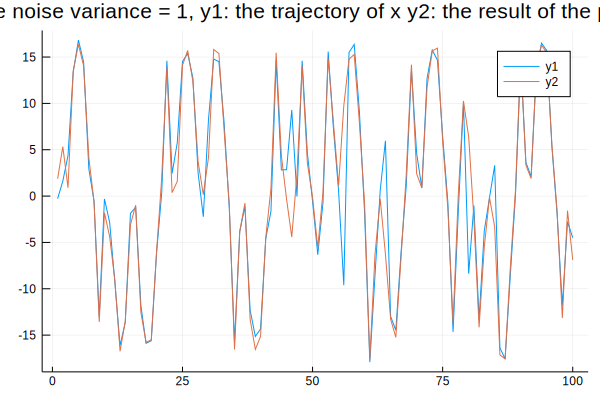

In [12]:
#--------------------------
# Graphic output
#--------------------------
N=1000
x_prediction=particle_filter(data, x_0, x_t, conditional_likelihoods, N, T, 1)
plot(x_prediction, title="The state noise variance = 1, y1: the trajectory of x  y2: the result of the particle filter")
plot!(xt)

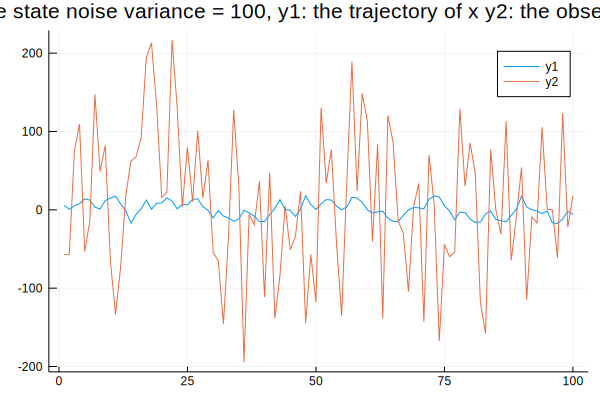

In [13]:
data = generate_data(x_0, x_t, y_t, T, 100)
xt = data[1]
yt = data[2]
plot(xt, title="The state noise variance = 100, y1: the trajectory of x  y2: the observation")
plot!(yt)

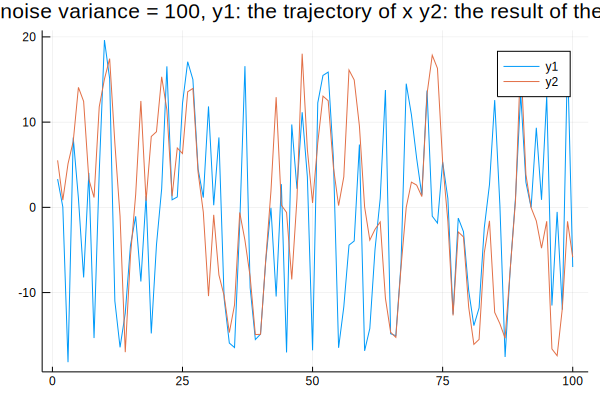

In [14]:
N=1000
x_prediction=particle_filter(data, x_0, x_t, conditional_likelihoods, N, T, 100)
plot(x_prediction, title="The state noise variance = 100, y1: the trajectory of x  y2: the result of the particle filter")
plot!(xt)

 What occurs as the state noise variance increases ? Explanations ?
 
 When the state noise variance increase, we find that the noise covers the trajectory of x, but the generation of weights follow the gausse distribution with mean equals the obsevation value at time t and variance equals R, even through the variance increases, we have enough particles that it's possible for us to get a good result.   

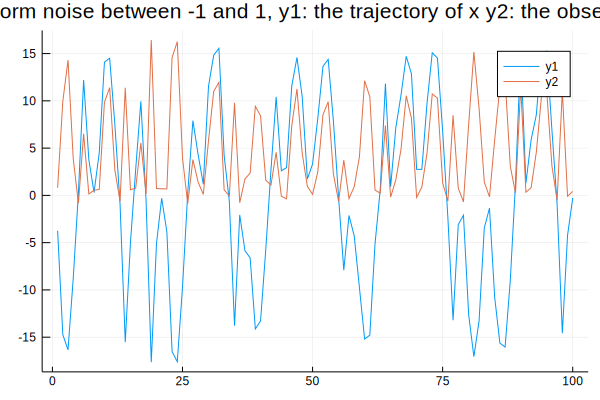

In [15]:
#observation equation
function y_t(h_t, x_cur, R = 1)
    return h_t.(x_cur) + rand(Uniform(-1, 1), length(x_cur))
end

T = 100
data = generate_data(x_0, x_t, y_t, T, 1)
xt = data[1]
yt = data[2]
plot(xt, title="Uniform noise between -1 and 1, y1: the trajectory of x  y2: the observation")
plot!(yt)

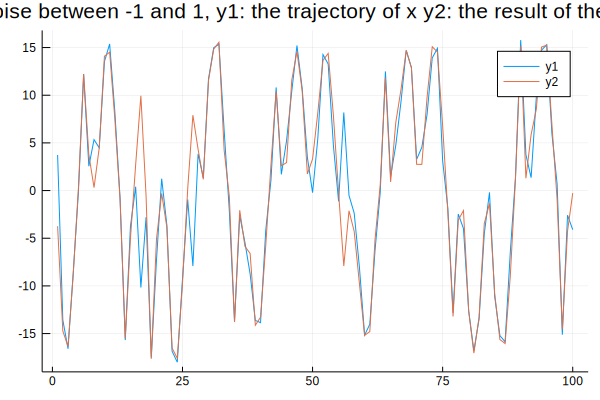

In [16]:
N=1000
x_prediction=particle_filter(data, x_0, x_t, conditional_likelihoods, N, T, 1)
plot(x_prediction, title="Uniform noise between -1 and 1, y1: the trajectory of x  y2: the result of the particle filter")
plot!(xt)

Comment: Even for uniform noise, particle filter can still work well.